<a href="https://colab.research.google.com/github/kashindra-mahato/SOC-support-system/blob/kashindra/authlog_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

##Imports

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
import matplotlib.pyplot as plt
import pickle
import joblib

##Parser for auth

In [3]:
def authParser(log_file):
  file_name = log_file
  file = open(file_name, "r")
  data = []
  order = ["date", "time", "ip", "process", "event"]
  
  for line in file.readlines():
    split1 = re.split(":", line, 3)
    event = split1[3]
    date = re.findall("^\S+\s+[0-9]{2}", line)
    time = re.findall("([0-9]{2}\\:[0-9]{2}\\:[0-9]{2})", line)[0]
    ip = re.findall("([a-z]{2}\\-[0-9]*\\-[0-9]*\\-[0-9]*\\-[0-9]*)", line)[0]
    process = re.findall("([a-zA-Z]*\\[[0-9]*\\])", line)[0]
    details = [date, time, ip, process, event]
    structure = {key:value for key, value in zip(order, details)}
    data.append(structure)
  return data

##parser for single line(string)

In [4]:
def authParserLine(line):
  order = ["date", "time", "ip", "process", "event"]
  
  split1 = re.split(":", line, 3)
  event = split1[3]
  date = re.findall("^\S+\s+[0-9]{2}", line)
  time = re.findall("([0-9]{2}\\:[0-9]{2}\\:[0-9]{2})", line)[0]
  ip = re.findall("([a-z]{2}\\-[0-9]*\\-[0-9]*\\-[0-9]*\\-[0-9]*)", line)[0]
  process = re.findall("([a-zA-Z]*\\[[0-9]*\\])", line)[0]
  details = [date, time, ip, process, event]
  structure = {key:value for key, value in zip(order, details)}
  
  return structure

##function for Cleaning

In [5]:
def clean(dataframe, column_name):
  dataframe[column_name] = dataframe[column_name].str.lower()
  # Remove numbers and special-characters from Event
  dataframe[column_name] = dataframe[column_name].str.replace('\d+', '')
  dataframe[column_name] = dataframe[column_name].str.replace(r'[^\w\s]+', '')
  # remove after 'user' including user :(
  dataframe[column_name] = dataframe[column_name].apply(lambda x: x.split(' user ')[0])
  return dataframe

##Stop word remover

In [6]:
def remStopWord(dataframe, column_name, s_words):
  import nltk
  from nltk.corpus import stopwords
  nltk.download('stopwords')
  all_stopwords = stopwords.words('english')
  all_stopwords.extend(s_words)
  dataframe[column_name] = dataframe[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords)]))
  return dataframe

##Tokenizer

In [7]:
def authToken(input_data):
  return list(set(str(input_data).split(' ')))

##Vectorizer

In [8]:
def authVectorizer(path, input_data):
  vectorizer = TfidfVectorizer(tokenizer=authToken)
  vectorizer.fit(input_data)
  vector_op = vectorizer.transform(input_data)
  pickle.dump(vectorizer, open(path + 'auth_vectorizer_model.sav', 'wb'))
#   joblib.dump(vectorizer, path + "auth_vectorizer_model.joblib", compress=True)

  return vector_op, vectorizer

##principle component analyzer

In [9]:
def pca(path, input_data):
  pca = PCA(n_components=0.95) 
  pca.fit(input_data)
  data = pca.transform(input_data)
  pickle.dump(pca, open(path + 'auth_pca_model.sav', 'wb'))
#   joblib.dump(pca, path + "auth_pca_model.joblib", compress=True)
  
  return data, pca

##training model

In [10]:
def train(path, input_data, mod):
  if mod == 'kmeans':
    model = KMeans(7)
    model.fit(input_data)
    data = model.transform(input_data)
    pickle.dump(model, open(path + 'auth_kmeans_model.sav', 'wb'))
#     joblib.dump(model, path + "auth_kmeans_model.joblib", compress=True)
    
    return data, model

  if mod == 'sgd':
    model = SGDClassifier(loss='perceptron')
    X = input_data.drop('y_label',axis=1)
    y = input_data['y_label']
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    model.fit(x_train, y_train)
    pickle.dump(model, open(path + 'auth_sgd_model.sav', 'wb'))
#     joblib.dump(model, path + "auth_sgd_model.joblib", compress=True)

    print(model.score(x_test, y_test))
    return model


##model loader

In [11]:
def loadModel(path, mod_name):
  return pickle.load(open(path + 'auth_'+mod_name+'.sav', 'rb'))

##function to calculate distance between each instance and their respective centroids

In [12]:
def fromCentDistance(pca_data, model):
  centroids = model.cluster_centers_
  df_cent = pd.DataFrame(centroids)
  df_cent['label'] = [i for i in range(len(centroids))]
  df_pca_data = pd.DataFrame(pca_data)
  df_pca_data['label'] = model.predict(pca_data)
  df_pca_data_join = df_pca_data.join(df_cent, 
                                      on='label', 
                                      how='left', 
                                      lsuffix='_pca',
                                      rsuffix='_cent')
  df_pca_1 = df_pca_data_join.loc[:, "0_pca":"label_pca"]
  df_pca_1.drop('label_pca', axis=1, inplace=True)
  df_cent_1 = df_pca_data_join.loc[:, "0_cent":"label_cent"]
  df_cent_1.drop('label_cent', axis=1, inplace=True)
  list1 = df_pca_1.to_numpy().tolist()
  list2 = df_cent_1.to_numpy().tolist()
  distances = []
  for i in range(len(list1)):
    dist = distance.euclidean(list1[i],list2[i])
    distances.append(dist)
  
  return distances

##function to calculate modified_zscore

In [13]:
def modified_zscore(distance, consistency_correction=1.4826):
    
    median = np.median(distance)
    
    deviation_from_med = np.array(distance) - median
    
    mad = np.mean(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    
    return mod_zscore, mad

##function to plot anomalies(z>3)

In [14]:
def plot_anomaly(data, threshold):
    data = data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(data), len(data))
    mask_outliers = (data > threshold)
    
    plt.figure(dpi=100)
    plt.plot(ranks[mask_outliers], data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], data[~mask_outliers],'o', color='b', label='normal')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. Log Event', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Event')
    plt.ylabel('Modified z-score')
    plt.show()

#Training

In [15]:
# log = "/content/drive/MyDrive/Colab Notebooks/DATASET/auth.log"
log = '/home/iamdpk/Project Work/SOC-support-system/Dataset/auth.log'

In [16]:
# path = '/home/iamdpk/Project Work/SOC-support-system/resources/auth_system/'
path = '/home/iamdpk/Project Work/SOC-support-system/backend/soc/mlmodels/auth_system/'

In [17]:
data = authParser(log)
data

[{'date': ['Nov 30'],
  'time': '06:39:00',
  'ip': 'ip-172-31-27-153',
  'process': 'CRON[21882]',
  'event': ' pam_unix(cron:session): session closed for user root\n'},
 {'date': ['Nov 30'],
  'time': '06:47:01',
  'ip': 'ip-172-31-27-153',
  'process': 'CRON[22087]',
  'event': ' pam_unix(cron:session): session opened for user root by (uid=0)\n'},
 {'date': ['Nov 30'],
  'time': '06:47:03',
  'ip': 'ip-172-31-27-153',
  'process': 'CRON[22087]',
  'event': ' pam_unix(cron:session): session closed for user root\n'},
 {'date': ['Nov 30'],
  'time': '07:07:14',
  'ip': 'ip-172-31-27-153',
  'process': 'sshd[22116]',
  'event': ' Connection closed by 122.225.103.87 [preauth]\n'},
 {'date': ['Nov 30'],
  'time': '07:07:35',
  'ip': 'ip-172-31-27-153',
  'process': 'sshd[22118]',
  'event': ' Connection closed by 122.225.103.87 [preauth]\n'},
 {'date': ['Nov 30'],
  'time': '07:08:13',
  'ip': 'ip-172-31-27-153',
  'process': 'sshd[22120]',
  'event': ' Connection closed by 122.225.103.87

In [18]:
df = pd.DataFrame(data)
df

,date,time,ip,process,event
0,[Nov 30],06:39:00,ip-172-31-27-153,CRON[21882],pam_unix(cron:session): session closed for us...
1,[Nov 30],06:47:01,ip-172-31-27-153,CRON[22087],pam_unix(cron:session): session opened for us...
2,[Nov 30],06:47:03,ip-172-31-27-153,CRON[22087],pam_unix(cron:session): session closed for us...
3,[Nov 30],07:07:14,ip-172-31-27-153,sshd[22116],Connection closed by 122.225.103.87 [preauth]\n
4,[Nov 30],07:07:35,ip-172-31-27-153,sshd[22118],Connection closed by 122.225.103.87 [preauth]\n
...,...,...,...,...,...
86834,[Dec 31],22:26:20,ip-172-31-27-153,sshd[7998],Connection closed by 218.2.0.133 [preauth]\n
86835,[Dec 31],22:27:07,ip-172-31-27-153,sshd[8001],Connection closed by 218.2.0.133 [preauth]\n
86836,[Dec 31],22:27:48,ip-172-31-27-153,sshd[8003],Invalid user admin from 218.2.0.133\n
86837,[Dec 31],22:27:48,ip-172-31-27-153,sshd[8003],input_userauth_request: invalid user admin [p...


In [19]:
df_copy = df.copy()

In [20]:
df_clean = clean(df,"event")
df_clean

<ipython-input-5-4ca01a1ba164>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[column_name] = dataframe[column_name].str.replace('\d+', '')
<ipython-input-5-4ca01a1ba164>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[column_name] = dataframe[column_name].str.replace(r'[^\w\s]+', '')


,date,time,ip,process,event
0,[Nov 30],06:39:00,ip-172-31-27-153,CRON[21882],pam_unixcronsession session closed for
1,[Nov 30],06:47:01,ip-172-31-27-153,CRON[22087],pam_unixcronsession session opened for
2,[Nov 30],06:47:03,ip-172-31-27-153,CRON[22087],pam_unixcronsession session closed for
3,[Nov 30],07:07:14,ip-172-31-27-153,sshd[22116],connection closed by preauth\n
4,[Nov 30],07:07:35,ip-172-31-27-153,sshd[22118],connection closed by preauth\n
...,...,...,...,...,...
86834,[Dec 31],22:26:20,ip-172-31-27-153,sshd[7998],connection closed by preauth\n
86835,[Dec 31],22:27:07,ip-172-31-27-153,sshd[8001],connection closed by preauth\n
86836,[Dec 31],22:27:48,ip-172-31-27-153,sshd[8003],invalid
86837,[Dec 31],22:27:48,ip-172-31-27-153,sshd[8003],input_userauth_request invalid


In [21]:
stopwords = ['pam_unixcronsession','' 'by', 'string', 'from', 'bye', 'for', 'port', 'sshd', 'ssh', 'root', 'preauth']
stopwords

['pam_unixcronsession',
 'by',
 'string',
 'from',
 'bye',
 'for',
 'port',
 'sshd',
 'ssh',
 'root',
 'preauth']

In [22]:
df_clean = remStopWord(df_clean, "event", stopwords)
df_clean

[nltk_data] Downloading package stopwords to /home/iamdpk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,date,time,ip,process,event
0,[Nov 30],06:39:00,ip-172-31-27-153,CRON[21882],session closed
1,[Nov 30],06:47:01,ip-172-31-27-153,CRON[22087],session opened
2,[Nov 30],06:47:03,ip-172-31-27-153,CRON[22087],session closed
3,[Nov 30],07:07:14,ip-172-31-27-153,sshd[22116],connection closed
4,[Nov 30],07:07:35,ip-172-31-27-153,sshd[22118],connection closed
...,...,...,...,...,...
86834,[Dec 31],22:26:20,ip-172-31-27-153,sshd[7998],connection closed
86835,[Dec 31],22:27:07,ip-172-31-27-153,sshd[8001],connection closed
86836,[Dec 31],22:27:48,ip-172-31-27-153,sshd[8003],invalid
86837,[Dec 31],22:27:48,ip-172-31-27-153,sshd[8003],input_userauth_request invalid


In [23]:
vector_op, vectorizer = authVectorizer(path, df_clean['event'])
display(vector_op)
display(vectorizer)

/home/iamdpk/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<86839x277 sparse matrix of type '<class 'numpy.float64'>'
	with 220161 stored elements in Compressed Sparse Row format>

TfidfVectorizer(tokenizer=<function authToken at 0x7faf88962940>)

In [24]:
pca_data, pca = pca(path, vector_op.todense())

/home/iamdpk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/iamdpk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [25]:
model_data, model = train(path, pca_data, 'kmeans')

In [26]:
distance = fromCentDistance(pca_data, model)

In [27]:
df_copy['distance'] = distance

In [28]:
distance

[0.48432229045132835,
 0.880880773702907,
 0.48432229045132835,
 0.6037538806419032,
 0.6037538806419032,
 0.6037538806419032,
 0.880880773702907,
 0.48432229045132835,
 0.880880773702907,
 0.48432229045132835,
 3.1600414965168207e-14,
 3.1336344735529374e-14,
 5.4058784020165535e-14,
 0.9750390553200646,
 0.880880773702907,
 0.48432229045132835,
 0.9750390553200646,
 0.880880773702907,
 0.48432229045132835,
 0.9750390553200646,
 0.9750390553200646,
 0.6037538806419032,
 0.6037538806419032,
 3.1600414965168207e-14,
 3.1336344735529374e-14,
 0.6037538806419032,
 0.880880773702907,
 0.48432229045132835,
 0.6037538806419032,
 0.6037538806419032,
 0.6037538806419032,
 0.6037538806419032,
 0.6037538806419032,
 0.6037538806419032,
 0.6037538806419032,
 0.0003375903413038142,
 0.880880773702907,
 0.48432229045132835,
 0.880880773702907,
 0.48432229045132835,
 5.4058784020165535e-14,
 0.9750390553200646,
 0.9750390553200646,
 0.9750390553200646,
 0.9750390553200646,
 0.9750390553200646,
 0.975

In [29]:
df_copy['label'] = model.labels_
df_copy['label']

0        5
1        5
2        5
3        5
4        5
        ..
86834    5
86835    5
86836    0
86837    3
86838    5
Name: label, Length: 86839, dtype: int32

In [30]:
mod_zscore, mad = modified_zscore(df_copy['distance'])

In [31]:
df_copy['mod_zscore'] = mod_zscore.tolist()

In [32]:
df_copy.loc[df_copy.mod_zscore>3, 'y_label'] = 'anomaly'
df_copy.loc[df_copy.mod_zscore<3, 'y_label'] = 'normal'

In [33]:
df_sgd = pd.DataFrame(vector_op.todense())

In [34]:
df_sgd['y_label'] = df_copy['y_label']

In [35]:
model = train(path, df_sgd, 'sgd')

1.0


#Output

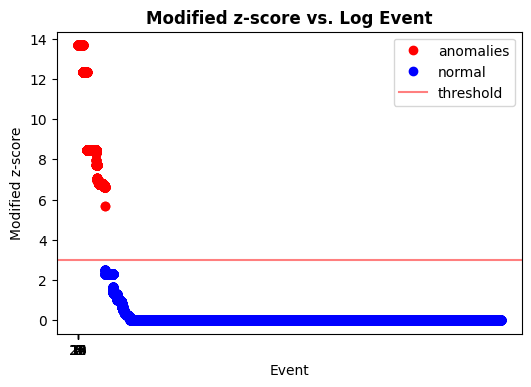

In [36]:
plot_anomaly(df_copy['mod_zscore'],3)

In [37]:
df.loc[df_copy.mod_zscore>3].event.unique()

array(['session closed', 'session opened', 'connection closed',
       'receive identification',
       'warning cant get client address connection reset peer',
       'could write ident unknown', 'could write ident',
       'received disconnect comjcraftjschjschexception auth fail',
       'fatal write failed connection reset peer',
       'address maps hostedbyleasewebcom map back address possible breakin attempt',
       'bad protocol version identification',
       'address maps stlinesiscom map back address possible breakin attempt',
       'bad protocol version identification get http',
       'address maps bnbr map back address possible breakin attempt',
       'address maps reversecompletelnet map back address possible breakin attempt',
       'corrupted mac input',
       'address maps peditasailorprocom map back address possible breakin attempt',
       'address maps servertrafficjockeycom map back address possible breakin attempt',
       'address maps hostedbyhostbasketcom 

In [38]:
df_copy.loc[df_copy.mod_zscore>3].event.unique()

array([' pam_unix(cron:session): session closed for user root\n',
       ' pam_unix(cron:session): session opened for user root by (uid=0)\n',
       ' Connection closed by 122.225.103.87 [preauth]\n',
       ' Did not receive identification string from 187.12.249.74\n',
       ' Did not receive identification string from 196.200.90.236\n',
       ' Did not receive identification string from 1.93.26.70\n',
       ' Did not receive identification string from 122.225.109.208\n',
       ' Connection closed by 122.225.109.208 [preauth]\n',
       ' Connection closed by 122.225.109.123 [preauth]\n',
       ' Connection closed by 218.2.0.129 [preauth]\n',
       ' Connection closed by 218.2.0.121 [preauth]\n',
       ' Did not receive identification string from 218.75.153.170\n',
       " warning: can't get client address: Connection reset by peer\n",
       ' Could not write ident string to UNKNOWN\n',
       ' Could not write ident string to 218.75.153.170\n',
       ' Did not receive iden

In [39]:
df.loc[df_copy.label == 0].event.unique()

array(['invalid'], dtype=object)

In [40]:
df.loc[df_copy.label == 1].event.unique()

array(['received disconnect'], dtype=object)

In [41]:
df.loc[df_copy.label == 2].event.unique()

array(['reverse mapping checking getaddrinfo internetsxcn failed possible breakin attempt',
       'reverse mapping checking getaddrinfo telemarnetbr failed possible breakin attempt',
       'reverse mapping checking getaddrinfo nslocal failed possible breakin attempt',
       'reverse mapping checking getaddrinfo dialwzzjdynamicdatacomcn failed possible breakin attempt',
       'reverse mapping checking getaddrinfo xxxstaticbusinesschelnyertelecomru failed possible breakin attempt',
       'reverse mapping checking getaddrinfo customertdatabrasilnetbr failed possible breakin attempt',
       'reverse mapping checking getaddrinfo adsldynamicseednettw failed possible breakin attempt',
       'reverse mapping checking getaddrinfo staticbjtelecomnet failed possible breakin attempt',
       'address maps hostedbyleasewebcom map back address possible breakin attempt',
       'reverse mapping checking getaddrinfo customeruninetidecommx failed possible breakin attempt',
       'reverse mappin

In [42]:
df.loc[df_copy.label == 3].event.unique()

array(['input_userauth_request invalid'], dtype=object)

In [43]:
df.loc[df_copy.label == 4].event.unique()

array(['fatal read socket failed connection reset peer',
       'fatal write failed connection reset peer'], dtype=object)

In [44]:
df.loc[df_copy.label == 5].event.unique()

array(['session closed', 'session opened', 'connection closed',
       'receive identification',
       'warning cant get client address connection reset peer',
       'could write ident unknown', 'could write ident',
       'received disconnect comjcraftjschjschexception auth fail',
       'bad protocol version identification',
       'bad protocol version identification get http',
       'corrupted mac input',
       'received disconnect javanetsockettimeoutexception read timed',
       'received disconnect supported authentication methods available',
       'received disconnect ok'], dtype=object)

In [45]:
df.loc[df_copy.label == 6].event.unique()

array(['disconnecting many authentication failures'], dtype=object)

#Testing

In [46]:
input = "Nov 30 09:22:03 ip-172-31-27-153 sshd[22218]: Did not receive identification string from 196.200.90.236"

In [47]:
data1 = authParserLine(input)

In [48]:
df1 = pd.DataFrame(data1)

In [49]:
df1

,date,time,ip,process,event
0,Nov 30,09:22:03,ip-172-31-27-153,sshd[22218],Did not receive identification string from 19...


In [50]:
df1_copy = df1.copy()

In [51]:
df1_clean = clean(df1,"event")

<ipython-input-5-4ca01a1ba164>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[column_name] = dataframe[column_name].str.replace('\d+', '')
<ipython-input-5-4ca01a1ba164>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe[column_name] = dataframe[column_name].str.replace(r'[^\w\s]+', '')


In [52]:
stopwords1 = ['pam_unixcronsession' 'by', 'string', 'from', 'bye', 'for', 'port', 'sshd', 'ssh', 'root', 'preauth']

In [53]:
df1_clean = remStopWord(df1_clean, "event", stopwords1)

[nltk_data] Downloading package stopwords to /home/iamdpk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
loaded_vectorizer = loadModel(path,'vectorizer_model')

In [55]:
vector_op1 = loaded_vectorizer.transform(df1_clean['event'])

In [56]:
loaded_pca = loadModel(path,'pca_model')

In [57]:
pca_data1 = loaded_pca.transform(vector_op1.todense())

/home/iamdpk/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [58]:
loaded_model_kmeans = loadModel(path,'kmeans_model')

In [59]:
model_data1 = loaded_model_kmeans.predict(pca_data1)

In [60]:
model_data1

array([5], dtype=int32)

In [61]:
loaded_model2 = loadModel(path,'sgd_model')

In [62]:
model_data2 = loaded_model2.predict(pd.DataFrame(vector_op1.todense()))
model_data2

array(['anomaly'], dtype='<U7')

model_data2

In [63]:
list = model_data2.tolist()[0]
list

'anomaly'